# Processing Munoz 2016

* Library targeting 2,722 genes with an average of 20 constructs per gene
* sgRNAs designed against the N-terminus of protein coding genes
* sgRNAs annotated with GC content, SNAP overlap, expression, off-targets, unclear how this information was used to filtered

In [1]:
import pandas as pd
import poola.core as pool
import seaborn as sns
import matplotlib.pyplot as plt
import gpplot
from core import add_transform_col

In [2]:
zscore_df = pd.read_csv("../data/external/Munoz2016_zscores_S4.csv")
essential_genes = pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/human/essential-genes-Hart2015.txt',
                                names=['GENE'])
nonessential_genes = pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/human/non-essential-genes-Hart2014.txt',
                                   names=['GENE'])


/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (32,35,37,38,43) have mixed types.Specify dtype option on import or set low_memory=False.


In [3]:
unique_zscores = (zscore_df[['sgRNASeq',
                             'RKO Z-score', 'DLD1 Z-score',
                             'NCI-H1299 Z-score']].drop_duplicates()
                  .dropna())

### Cell Line Correlation

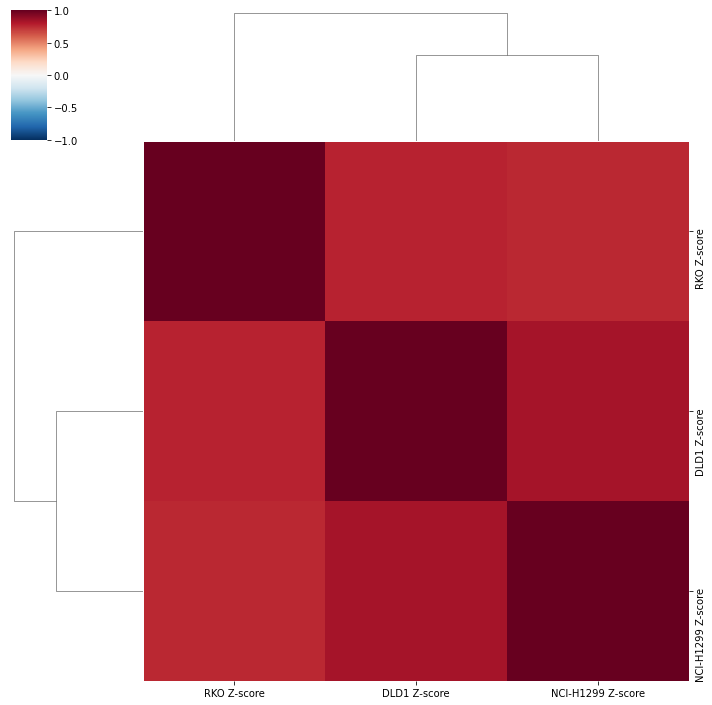

In [4]:
cors = unique_zscores[['RKO Z-score', 'DLD1 Z-score',
                       'NCI-H1299 Z-score']].corr()
sns.clustermap(cors, cmap='RdBu_r', vmin=-1, vmax=1)

In [5]:
long_zscores = (unique_zscores.melt(id_vars='sgRNASeq',
                                    var_name='condition',
                                    value_name='z-score'))

## Merging with designs

In [6]:
sg_list = list(long_zscores['sgRNASeq'].unique())
design_df = pd.read_parquet('/Volumes/GoogleDrive/Shared drives/GPP Cloud /R&D/People/Peter/gpp-annotation-files/sgRNA_design_9606_GRCh38_SpyoCas9_CRISPRko_Ensembl_20200401.parquet',
                            filters=[[('sgRNA Sequence', 'in', sg_list)]])

In [7]:
zscore_designs = (long_zscores.rename({'sgRNASeq': 'sgRNA Sequence'}, axis=1)
                  .merge(design_df, how='inner',
                         on='sgRNA Sequence'))

In [8]:
print('Nonessentials: ' + str(zscore_designs['Target Gene Symbol'].isin(nonessential_genes.GENE).sum()))

Nonessentials: 1710


In [9]:
print('Essentials: ' + str(zscore_designs['Target Gene Symbol'].isin(essential_genes.GENE).sum()))


Essentials: 66579


In [10]:
roc_aucs, _ = pool.get_roc_aucs(lfcs=zscore_designs, tp_genes=essential_genes.GENE,
                                fp_genes=nonessential_genes.GENE, gene_col='Target Gene Symbol',
                                condition_col='condition', score_col='z-score')
roc_aucs

,condition,ROC-AUC
0,DLD1 Z-score,0.895413
1,NCI-H1299 Z-score,0.794576
2,RKO Z-score,0.895761


In [11]:
roc_aucs.mean()

ROC-AUC    0.861917
dtype: float64

In [12]:
ess_zscores = (zscore_designs[zscore_designs['Target Gene Symbol'].isin(essential_genes.GENE)])
print('Essential sgRNAs ' + str(int(ess_zscores.shape[0])))
filtered_zscores = (ess_zscores[(ess_zscores['# Off-Target Tier I Match Bin I Matches'] == '0')]
                    .reset_index(drop=True))
print('Off target filtered: ' + str(int((ess_zscores.shape[0] - filtered_zscores.shape[0])/5)))
remaining_gene_count = (filtered_zscores[['sgRNA Context Sequence', 'Target Cut %', 'Target Gene Symbol']]
                        .drop_duplicates()
                        ['Target Gene Symbol']
                        .value_counts())
keep_genes = remaining_gene_count.index[remaining_gene_count > 1]
filtered_zscores = filtered_zscores[filtered_zscores['Target Gene Symbol'].isin(keep_genes)]

Essential sgRNAs 66579
Off target filtered: 634


In [13]:
filtered_zscores['neg_zscore'] = -filtered_zscores['z-score']
filtered_zscores = add_transform_col(df=filtered_zscores,
                                     col='neg_zscore',
                                     transform_name='yeo-johnson',
                                     transformed_name='gene_scaled_neg_zscore',
                                     group_col=['Target Gene Symbol', 'condition'])
sg_avg_score = (filtered_zscores.groupby(['sgRNA Sequence', 'sgRNA Context Sequence', 'Target Gene Symbol',
                                          'Target Cut %', 'On-Target Efficacy Score'])
                .agg({'gene_scaled_neg_zscore': 'mean'})
                .reset_index())
sg_avg_score['gene_scaled_neg_zscore'] = ((sg_avg_score['gene_scaled_neg_zscore'] - sg_avg_score['gene_scaled_neg_zscore'].mean())/
                                          sg_avg_score['gene_scaled_neg_zscore'].std())

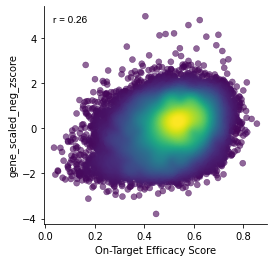

In [14]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=sg_avg_score, y='gene_scaled_neg_zscore', x='On-Target Efficacy Score')
gpplot.add_correlation(data=sg_avg_score, y='gene_scaled_neg_zscore', x='On-Target Efficacy Score')
sns.despine()

In [15]:
training_data = sg_avg_score.drop('On-Target Efficacy Score', axis=1)
training_data

,sgRNA Sequence,sgRNA Context Sequence,Target Gene Symbol,Target Cut %,gene_scaled_neg_zscore
0,AAAAAAAGGCTGGGCCTTCC,TGGGAAAAAAAGGCTGGGCCTTCCAGGGGA,PRKDC,65.6,-0.531869
1,AAAAAAAGGGCTGCCCCAAA,TGCCAAAAAAAGGGCTGCCCCAAAAGGAAC,TOP2A,93.8,-1.185293
2,AAAAAAATCCAGCAATGCAG,CTAGAAAAAAATCCAGCAATGCAGAGGTGA,SHOC2,15.0,-0.077431
3,AAAAAACCTGTCCCCTGGTG,GGAAAAAAAACCTGTCCCCTGGTGCGGTGG,COPA,14.2,-0.799080
4,AAAAAAGCAGCTGCTTTCAG,TCCAAAAAAAGCAGCTGCTTTCAGAGGAGG,TTK,22.8,0.391569
...,...,...,...,...,...
21131,TTTGTTCTTTAAATGGCTAC,CAAATTTGTTCTTTAAATGGCTACAGGAGG,MED12,45.1,-1.951933
21132,TTTGTTCTTTCTGTGCGCAC,AGATTTTGTTCTTTCTGTGCGCACTGGTGA,PTPN11,25.5,-1.693789
21133,TTTGTTGAGGCTCCTGGCTG,AAGATTTGTTGAGGCTCCTGGCTGTGGCGA,RPTOR,54.7,-1.234981
21134,TTTGTTGCCAATAGTTGGCC,TCTTTTTGTTGCCAATAGTTGGCCTGGCAA,SKP2,93.7,-0.871017


In [16]:
training_data.to_csv('../data/processed/Munoz2016_activity.csv', index=False)